#Todos


Data
- Load Data
- Preprocessing? (Stop Words, Links, User Names, HTML Tags)

Topic Model
- LDA (Latent Dirichlet Allocation)


Model Evaluation:
- Print Results: Topics, Topic Members (e.g. nearest neighbour document) (https://asistdl.onlinelibrary.wiley.com/doi/full/10.1002/asi.23786
)

- global (topic coherence, topic diversity)
- instance based/local
- features


Contextual Embeddings
- USE (https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=RUymE2l9GZfO)
- Dimensionality reduction (PCA, (UMAP), MDS) (Curse of dimensionality)
- Clustering (Choose method: k-means, spectral, density-based methods https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction to 2D (T-SNE, UMAP)
- make interactive map?

Model Evaluation:
- global
- instance based/local
- features

##Load Data

In [1]:
import os

os.chdir(os.path.expanduser('~'))
import gdown
zip_folder_name = 'youtube_comments_climate_change'

shared_google_drive_link = 'https://drive.google.com/uc?id=1vca7QCLO6oMkbKiK_8Xa7IJj0HhqkEb3'
output = zip_folder_name+'.zip'
gdown.download(shared_google_drive_link,output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('')


os.chdir(zip_folder_name) 

data_desciption_file = 'data_description.txt'

with open(data_desciption_file,'r') as myfile:
  f = myfile.read()
print(f)

Downloading...
From: https://drive.google.com/uc?id=1vca7QCLO6oMkbKiK_8Xa7IJj0HhqkEb3
To: /root/youtube_comments_climate_change.zip
5.30MB [00:00, 92.6MB/s]


Data description
__________________

// Project
data deluge

// Data mining
All data are extracted using the YouTube Data Tools (YTDT):
https://tools.digitalmethods.net/netvizz/youtube/
Specifically, comments are extracted using the video info and comments module
https://tools.digitalmethods.net/netvizz/youtube/mod_video_info.php

// Datasets

- videoinfo_xE0KtLy5j8w_2018_06_26-18_32_17_comments.xlsx
This dataset includes all text posted within the comments section of the video https://youtu.be/xE0KtLy5j8w (produced by Climate Central, featured by The Daily Conversation)
Additional variables such as time of posting, replies, likes, etc. have been removed from the dataset.
The comments were then coded by hand, in order to identify particular coping strategies of people making sense of the information shown in the video (sea level rise scenarios).

- videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab
Data gathered from the video https://youtu.be/VbiRNT_gWUQ, produced by the National 

### Open file as df and removing unused columns



In [2]:
import pandas as pd


path = "videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab - videoinfo_VbiRNT_gWUQ_2020_01_16-10_08_40_comments.tab.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8')
data = data.dropna(subset=['text', 'authorName']) # drop rows with no content

data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
data.head()

,publishedAt,authorName,text,isReply
0,2020-01-16 09:01:08,Lee McLellan,If all the ice melts surely the tilt of the ea...,0
1,2020-01-16 06:16:07,Aakash Majumdar,The scariest part of the video is the music......,0
2,2020-01-15 10:50:21,Glenn Davies,New Zealand be like...&quot;are we good?&quot;...,0
3,2020-01-15 08:35:50,Shane Meyer,Step #1: Taxes... Step #2: ???... Step #3: Utopia,0
4,2020-01-15 02:00:30,Rennie Allen,Strange how Hudson&#39;s Bay stayed the same s...,0


## Preprocessing

### Removing HTML tags

In [3]:
!pip3 install html2text

In [4]:
from html2text import HTML2Text
from tqdm import tqdm

tqdm.pandas()

h = HTML2Text()
h.ignore_links = True

data['text'] = data['text'].progress_apply(lambda x: h.handle(x))

100%|██████████| 25914/25914 [00:02<00:00, 9206.20it/s]


### Removing links

In [5]:
http_link_pattern = r'http\S+'
bitly_link_pattern = r'bit.ly/\S+'
data['text'] = data['text'].str.replace(http_link_pattern, '')
data['text'] = data['text'].str.replace(bitly_link_pattern, '')

### Removing user names

Only user names consisting of more than 3 characters are removed to avoid unintentionally joining words.

In [ ]:
import re

keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]

data['cleaned'] = data['text'].str.replace('|'.join(map(re.escape, user_names)), '')

## Topic Modelling

### Tokenizing



In [ ]:
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def clean_text(text):
    text = text.lower()
    text = re.sub('['+punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) # remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    return text

In [ ]:
import nltk
#nltk.download('punkt')
from tqdm import tqdm
import gensim
from gensim.utils import simple_preprocess

tqdm.pandas()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

data_cleaned = data['cleaned'].progress_apply(clean_text)
data_words = list(sent_to_words(data_cleaned))

Every comment ends up as a "cleaned" list of words.

In [ ]:
data_words[0]

['if',
 'all',
 'the',
 'ice',
 'melts',
 'surely',
 'the',
 'tilt',
 'of',
 'the',
 'earth',
 'will',
 'also',
 'change',
 'because',
 'of',
 'the',
 'weight',
 'diffrence',
 'at',
 'both',
 'poles',
 'and',
 'would',
 'this',
 'affect',
 'the',
 'land',
 'mass',
 'to',
 'change',
 'also']

### N-grams

An n-gram is a contiguous sequence of items in this case words. A bigram consists of two words, a trigram of three words.

The gensim Phrase detection automatically detects common sequences.

Important params for these n-grams are min_count and threshold. The higher these params harder it is for words to be combined. 

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

# Exporting the trained model means faster processing BUT model updates no longer possible.
bigram_mod = gensim.models.phrases.Phraser(bigram)

### Removing stop words, lemmatization

For using manually assembled stoplist, exchange "stop_words" for "stop_words_manually" in line 11

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
path = "stoplist.txt"
with open(path, encoding="utf16") as f:
  stop_words_manually = f.read().splitlines()

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(elem)) if word not in stop_words] for elem in texts]

def make_bigrams(texts):
    return [bigram_mod[elem] for elem in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


During lemmatization only nouns, adjectives, verbs, and adverbs are kept.

In [ ]:
import spacy

data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
data_lemmatized[0]

['ice',
 'melt',
 'surely',
 'tilt',
 'earth',
 'also',
 'change',
 'weight',
 'diffrence',
 'pole',
 'would',
 'affect',
 'land',
 'mass',
 'change',
 'also']

### LDA

The gensim LDA model needs dictionary(id2word) and corpus. The dictionary creates an unique id for all words, the corpus maps the id to the number of occurences in the model.

In [ ]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
corpus[0]

[(0, 1),
 (1, 2),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1)]

In [ ]:
id2word[0]

'affect'

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('affect', 1),
  ('also', 2),
  ('change', 2),
  ('diffrence', 1),
  ('earth', 1),
  ('ice', 1),
  ('land', 1),
  ('mass', 1),
  ('melt', 1),
  ('pole', 1),
  ('surely', 1),
  ('tilt', 1),
  ('weight', 1),
  ('would', 1)]]

Aside from corpus and dictionary, the model takes the number of topics, chunksize (number of documents to be used in each training chunk increasing chunksize speed up training), and passes (epochs) as input.

In [ ]:
num_topics = 10
chunksize = 100
passes = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=chunksize,
                                       passes=passes,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.072*"look" + 0.054*"bad" + 0.044*"would" + 0.040*"flood" + 0.038*"go" + '
  '0.037*"lol" + 0.036*"think" + 0.033*"place" + 0.027*"state" + '
  '0.023*"affect"'),
 (1,
  '0.037*"video" + 0.030*"area" + 0.026*"make" + 0.023*"problem" + '
  '0.023*"care" + 0.022*"right" + 0.021*"music" + 0.017*"leave" + 0.017*"last" '
  '+ 0.017*"survive"'),
 (2,
  '0.055*"city" + 0.047*"get" + 0.044*"still" + 0.037*"good" + 0.027*"big" + '
  '0.023*"thing" + 0.021*"live" + 0.017*"find" + 0.017*"need" + 0.017*"let"'),
 (3,
  '0.043*"say" + 0.039*"people" + 0.028*"many" + 0.025*"come" + 0.023*"much" + '
  '0.021*"die" + 0.020*"want" + 0.019*"year" + 0.018*"life" + 0.017*"take"'),
 (4,
  '0.042*"know" + 0.030*"even" + 0.025*"time" + 0.021*"think" + 0.019*"really" '
  '+ 0.018*"fuck" + 0.018*"move" + 0.017*"get" + 0.016*"may" + 0.015*"world"'),
 (5,
  '0.117*"water" + 0.097*"ice" + 0.044*"melt" + 0.038*"level" + 0.035*"would" '
  '+ 0.033*"show" + 0.028*"land" + 0.022*"rise" + 0.021*"sea" + 0.017*"

In [ ]:
from gensim.models import CoherenceModel

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # the lower the better.

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.082126696518344

Coherence Score:  0.5041024269591217


### Hyperparameter Tuning

Alpha and beta are hyperparameters that affect sparsity of the topics

[As seen here.](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

**The script runs for about 1:50h.**

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  0%|          | 0/270 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
100%|██████████| 270/270 [7:08:57<00:00, 95.33s/it] 


### Analyzing results of hyperparameter tuning

In [ ]:
path = "lda_tuning_results.csv"
lda_results = pd.read_csv(path, sep=",", encoding='utf-8')

list(lda_results.columns)

['Validation_Set', 'Topics', 'Alpha', 'Beta', 'Coherence']

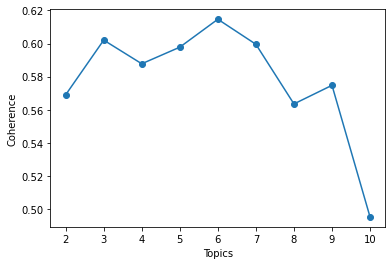

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

coherence = lda_results.loc[np.logical_and(lda_results.Alpha == "0.01", lda_results.Beta == "0.01")]['Coherence']
topics = lda_results.loc[np.logical_and(lda_results.Alpha == "0.01", lda_results.Beta == "0.01")]['Topics']

plt.plot(topics, coherence, linestyle='-', marker='o')
plt.ylabel('Coherence')
plt.xlabel('Topics')
plt.show()

In [ ]:
lda_results.loc[lda_results.Topics == 8][['Topics', 'Alpha', 'Beta', 'Coherence']]

,Topics,Alpha,Beta,Coherence
180,8,0.01,0.01,0.563529
181,8,0.01,0.31,0.555529
182,8,0.01,0.61,0.537989
183,8,0.01,0.9099999999999999,0.587326
184,8,0.01,symmetric,0.574111
185,8,0.31,0.01,0.537229
186,8,0.31,0.31,0.510433
187,8,0.31,0.61,0.484110
188,8,0.31,0.9099999999999999,0.512353
189,8,0.31,symmetric,0.538294


In [ ]:
lda_results.loc[lda_results['Coherence'].idxmax()]

Validation_Set    100% Corpus
Topics                      3
Alpha              asymmetric
Beta                symmetric
Coherence            0.677208
Name: 59, dtype: object

In [ ]:
tuned_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="asymmetric",
                                           eta=0.01)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
from pprint import pprint

pprint(tuned_lda_model.print_topics())
doc_tuned_lda = tuned_lda_model[corpus]

[(0,
  '0.049*"go" + 0.045*"would" + 0.023*"think" + 0.023*"world" + 0.022*"get" + '
  '0.022*"know" + 0.020*"live" + 0.019*"look" + 0.019*"happen" + 0.018*"see"'),
 (1,
  '0.065*"make" + 0.046*"say" + 0.042*"take" + 0.040*"people" + 0.028*"lot" + '
  '0.026*"right" + 0.025*"many" + 0.024*"use" + 0.023*"put" + 0.022*"area"'),
 (2,
  '0.136*"water" + 0.109*"ice" + 0.077*"level" + 0.063*"sea" + 0.049*"melt" + '
  '0.047*"rise" + 0.046*"would" + 0.028*"land" + 0.026*"ocean" + 0.021*"high"'),
 (3,
  '0.054*"year" + 0.043*"change" + 0.037*"planet" + 0.031*"science" + '
  '0.029*"earth" + 0.026*"man" + 0.024*"time" + 0.024*"give" + 0.024*"back" + '
  '0.024*"come"')]


### Visual representation

Each blue circle represents a topic. The larger the bubble, the more prevalent the topic.

Relatively big, non-overlapping bubbles scattered throughout the chart are desirable.

By decreasing the value of lamda, more weight is put on the ratio of frequency given the topic to overall frequency of the word.

In [ ]:
!pip3 install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 16.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=ba5e79493b0945cec98409b2ff0b6713d7a8d8621d0af47b3fe0e79a6bcdacf9
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=3b2e516420c835f1a6d8fb9fd7717bb5777d063a69204e873be4659cbbe78a17
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(tuned_lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.188227  0.070822       1        1  46.073158
2      0.290670 -0.137735       2        1  20.792049
1     -0.312610 -0.258550       3        1  18.594707
3     -0.166287  0.325464       4        1  14.540081, topic_info=      Term         Freq        Total Category  logprob  loglift
51   water  5061.000000  5061.000000  Default  30.0000  30.0000
5      ice  4067.000000  4067.000000  Default  29.0000  29.0000
73   level  2865.000000  2865.000000  Default  28.0000  28.0000
238    sea  2327.000000  2327.000000  Default  27.0000  27.0000
42    make  2151.000000  2151.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
94    time   634.597168  1257.005981   Topic4  -3.7121   1.2448
191   come   619.718506  1209.142090   Topic4  -3.7358   1.2599
280   fact   385.812042   648.370117   Topic4  -4.2097   1.4091
91     say   460.149567  1978.421021   Topic4  -4.0335   0.4698
251  never   323.489075   592.347473   Topic4  -4.3859   1.3233

[178 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
81        3  1.000190  actually
189       4  1.000692       age
318       2  0.381697   already
318       3  0.617855   already
1         1  0.790317      also
...     ...       ...       ...
244       1  1.000227     world
13        1  0.682965     would
13        2  0.317071     would
55        3  0.316217      year
55        4  0.683992      year

[161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

#### Most representative topic for each comment


In [ ]:
from tqdm import tqdm

def show_comment_topics(ldamodel, corpus, documents):
    topics_data = pd.DataFrame()

    #iterate over model corpus
    for index, row in tqdm(enumerate(ldamodel[corpus])):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for i, (topic_num, prop_topic) in enumerate(row):
            if i == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_data = topics_data.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_data.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Append original comment at the end
    contents = pd.Series(documents['text'])
    topics_data = pd.concat([topics_data, contents], axis=1)
    return(topics_data)

data_topic_keywords = show_comment_topics(tuned_lda_model, corpus, data)

25914it [02:12, 196.15it/s]


In [ ]:
data_dominant_topic = data_topic_keywords.reset_index()
data_dominant_topic.columns = ['Comment Nr', 'Dominant Topic', '% of Topic in Comment', 'Keywords', 'Comment']

data_dominant_topic.loc[:, 'Dominant Topic':'Comment'].head(20)

,Dominant Topic,% of Topic in Comment,Keywords,Comment
0,2.0,0.5061,"water, ice, level, sea, melt, rise, would, lan...",If all the ice melts surely the tilt of the ea...
1,0.0,0.9128,"go, would, think, world, get, know, live, look...",The scariest part of the video is the music......
2,0.0,0.6948,"go, would, think, world, get, know, live, look...","New Zealand be like...""are we good?"" 🤷‍♂️\n\n"
3,0.0,0.8779,"go, would, think, world, get, know, live, look...",Step #1: Taxes... Step #2: ???... Step #3: Uto...
4,0.0,0.4632,"go, would, think, world, get, know, live, look...",Strange how Hudson's Bay stayed the same size....
5,0.0,0.3896,"go, would, think, world, get, know, live, look...",Sweet I'll have ocean front property.\n\n
6,0.0,0.4632,"go, would, think, world, get, know, live, look...",Brazil will lost 25% of territory 😂\n\n
7,0.0,0.5974,"go, would, think, world, get, know, live, look...",Lesson learned : dont put your capitol city ne...
8,2.0,0.4161,"water, ice, level, sea, melt, rise, would, lan...",If this was an actual concern...at all...then ...
9,0.0,0.4842,"go, would, think, world, get, know, live, look...","If I was 100 years old, i'll be the first to d..."


#### Most representative comments for each topic

Index shows original placement of commment

In [ ]:
top_comments_df = pd.DataFrame()

with pd.option_context('display.max_colwidth', None, 'display.max_rows', 20):
  for topic in data_topic_keywords.groupby('Dominant_Topic'):
      top_comments_df = pd.concat([top_comments_df, topic[1].sort_values(['Perc_Contribution'], ascending=[0]).head(5)])

  top_comments_df.columns= ['Dominant Topic', '% of Topic in Comment', 'Keywords', 'Comment']

top_comments_df

,Dominant Topic,% of Topic in Comment,Keywords,Comment
3535,0.0,0.9656,"go, would, think, world, get, know, live, look...",There will probably be a billion people living...
241,0.0,0.9593,"go, would, think, world, get, know, live, look...",So why is waterfront property still cost so mu...
5837,0.0,0.9589,"go, would, think, world, get, know, live, look...","From what I guess, most likely not but who kno..."
20842,0.0,0.9564,"go, would, think, world, get, know, live, look...",We do something against the rising water thoug...
24563,0.0,0.9561,"go, would, think, world, get, know, live, look...",Or Gambia.\n\n
503,1.0,0.9064,"make, say, take, people, lot, right, many, use...",Trees make air. \nPeople breath air. \nZero ...
1718,1.0,0.8942,"make, say, take, people, lot, right, many, use...",Baltics have left the chat Crimea can into isl...
74,1.0,0.8587,"make, say, take, people, lot, right, many, use...",Lets see which go underwater at times \n \n ...
1710,1.0,0.8519,"make, say, take, people, lot, right, many, use...",Delaware has left the chat Louisiana has left ...
15894,1.0,0.8519,"make, say, take, people, lot, right, many, use...",Good thing I don't live in Florida. Now Miami ...


#### Topic distribution

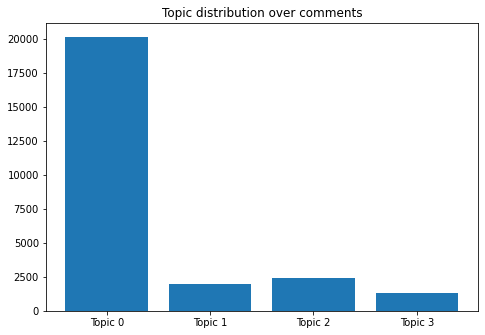

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

topic_count = data_topic_keywords['Dominant_Topic'].value_counts()

x = []
y = []

for i, topic in enumerate(topic_count):
    y.append(float(topic_count[i]))
    x.append('Topic {}'.format(i))

ax.bar(x,y)
ax.set_title('Topic distribution over comments')
plt.show()

#### Show topic distribution for single comment

In [ ]:
get_document_topics = tuned_lda_model.get_document_topics(corpus)

In [ ]:
comment_id = int(input())

get_document_topics[comment_id]

## Contextual Embeddings

### BERT

In [ ]:
!pip3 install transformers

In [ ]:
import torch
from transformers import BertTokenizerFast, BertTokenizer, BertModel

# Logging activation
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizerFast.from_pretrained(model_version)

In [ ]:
print('Original comment: ', len(data['cleaned'][0]))
print('Comments split into tokens: ', tokenizer.tokenize(data['cleaned'][0]))
print('Words in comment mapped to token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(data['cleaned'][0])))

#tokenize.encode does both steps

In [ ]:
print(sum(len(c) > 512 for c in data['cleaned']))

In [ ]:
tokenized= data['cleaned'].apply(lambda x: tokenizer.encode(x))

[101] is the token marking the beginning of an input [CLS]

[102] is the token marking th end of each sentence [SEP]

tokenized is every comment as list of token IDs

In [ ]:
import numpy as np
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape